In [1]:
import numpy as np
np.random.seed(523)
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from matplotlib import rcParams
rcParams.update({'figure.autolayout':True})
import statsmodels.api as sm
from scipy.sparse import coo_matrix, hstack

/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
## Helper function by dbaghern
## https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines

from sklearn.base import BaseEstimator, TransformerMixin

class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [3]:
def plot_roc (model, X, y):
    
    # model=lasso1
    # X = X_test_scaled
    # y = y_test

    # probabilities of ckd
    ckd_probs=model.predict_proba(X)[:,1]

    oneminusspec_list=[]
    sensitivity_list=[]

    threshes=np.linspace(0,1, 100)
    for thresh in threshes:
     
        # initialize the confusion matrix tally for this particular threshold
        TP=0
        FP=0
        FN=0
        TN=0
    
        # For every threshold, compute the confusion matrix values
        for obs_num in range(len(y)):
            if ckd_probs[obs_num]>=thresh:
                predict_sick=True
            else:
                predict_sick=False

            if y[obs_num]==1:
                sick=True
            else:
                sick=False

            if predict_sick and sick:
                TP += 1
            elif predict_sick and not sick:
                FP += 1
            elif not predict_sick and sick:
                FN += 1
            else:
                TN += 1

        # For every threshold, compute and record the oneminusspec
        # value and the sensitivity value
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        oneminusspec = 1 - specificity

        oneminusspec_list.append(oneminusspec)
        sensitivity_list.append(sensitivity)


    oneminusspec_list=list(reversed(oneminusspec_list))
    sensitivity_list=list(reversed(sensitivity_list))

    oneminusspec_list
    sensitivity_list

    figure, ax = plt.subplots(figsize=(7,7))
    plt.plot(oneminusspec_list, sensitivity_list)
    x=np.linspace(0,1, num=50)
    y=x
    plt.plot(x,y, 'r')
    ax.set_xlabel("False positive rate", fontsize=20)
    ax.set_ylabel("Sensitivity", fontsize=20)

# General Classification of Reddit Threads

## 1. TrainTestSplit and One-Hot Encoding of Subreddit

In [4]:
df=pd.read_pickle('./general_pickle')

In [5]:
X=df[['title', 'subreddit', 'elapsed', 'title_length', 'feature_question', 'feature_exclaim']]
y =df[['class']]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.3,
                                                   random_state=42)

In [7]:
X_train=X_train.copy()
X_test=X_test.copy()

In [8]:
mapping=X_train['subreddit'].value_counts()

In [9]:
# Dumping the less common subreddits into an "other" bin

def convert(x):
    try:
        if mapping[x]>10:
            return x
        else:
            return "other"
    except:
        return "other"

In [10]:
X_train['subreddit']=X_train['subreddit'].apply(convert)
X_test['subreddit']=X_test['subreddit'].apply(convert)

In [11]:
X_train=pd.get_dummies(X_train, prefix=['subreddit'], columns=['subreddit'], drop_first=True)
X_test=pd.get_dummies(X_test, prefix=['subreddit'], columns=['subreddit'], drop_first=True)

In [12]:
# Mismatch Correction Code Courtesy of Ben Shaver

model_cols = X_train.columns

def add_model_cols(data, model_cols):
    new_data = data.copy()
    for missing_col in [col for col in model_cols if col not in data.columns]:
        new_data[missing_col] = 0
    return new_data

X_test = add_model_cols(X_test, model_cols=model_cols)

In [13]:
X_train.shape

(4900, 96)

In [14]:
X_test.shape

(2100, 96)

## 2. Build Logistic Regression Pipeline

In [15]:
# This is the baseline accuracy score

baseline=y_train['class'].value_counts().max()/y_train.shape[0]
baseline

0.5004081632653061

In [16]:
y_train=y_train['class'].ravel()
y_test=y_test['class'].ravel()

In [17]:
# I closely followed a very helpful kaggle tutorial to figure out how to build
# a system of pipelines for heterogenous data
# https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines

In [18]:
nonword=list(X_train.columns)
del(nonword[0])



nonword_pipeline = Pipeline([
    ('selector', Selector(key=nonword)),
    ('ss', StandardScaler())
])



word_pipeline = Pipeline([
    ('selector', Selector(key='title')),
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])



merge = FeatureUnion([
    ('word', word_pipeline),
    ('nonword', nonword_pipeline)
])


main_pipeline = Pipeline([
    ('merger',merge),
    ('logreg', LogisticRegression()),
])

main_pipeline.fit(X_train, y_train)

In [24]:
main_pipeline.score(X_test, y_test)

0.5914285714285714

In [25]:
main_pipeline.score(X_train, y_train)

0.8369387755102041

## 3. Grid Search Logistic Regression Pipeline

In [26]:
# For convenience, git a directory of all possible tuning parameters

#list(main_pipeline.get_params().keys())

### 3.A. Hunting for best text vectorizer parameters

In [27]:
hyperparameters={
                'logreg__penalty': ['l2'],
                'logreg__C': [1], 
                'merger__word__tfidf__use_idf': [False],
                 'merger__word__vect__max_df': [0.01],
                 'merger__word__vect__ngram_range': [(1,3)],
                'merger__transformer_weights': [
                                                {'word': .75, 'nonword': .25},
                                                {'word': .80, 'nonword': .15}, 
                                                {'word': .95, 'nonword': .05},
                                                {'word':1, 'nonword': 0}]}

grid = GridSearchCV(main_pipeline, hyperparameters, cv=3)
 
# Fit and tune model
_=grid.fit(X_train, y_train)

In [28]:
grid.best_params_

{'logreg__C': 1,
 'logreg__penalty': 'l2',
 'merger__transformer_weights': {'word': 0.95, 'nonword': 0.05},
 'merger__word__tfidf__use_idf': False,
 'merger__word__vect__max_df': 0.01,
 'merger__word__vect__ngram_range': (1, 3)}

In [29]:
grid.score(X_train, y_train)

0.9112244897959184

In [30]:
grid.score(X_test, y_test)

0.59

In [31]:
tn, fp, fn, tp = confusion_matrix(y_test, grid.predict(X_test)).ravel()

In [32]:
# Specificity

tn/(fp+tn)

0.6522988505747126

In [33]:
# Sensitivity

tp/(fn+tp)

0.5284090909090909

### 3.B. Logistic had a hard time classifying these data.  ROC curve is pretty close to the diagonal.

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


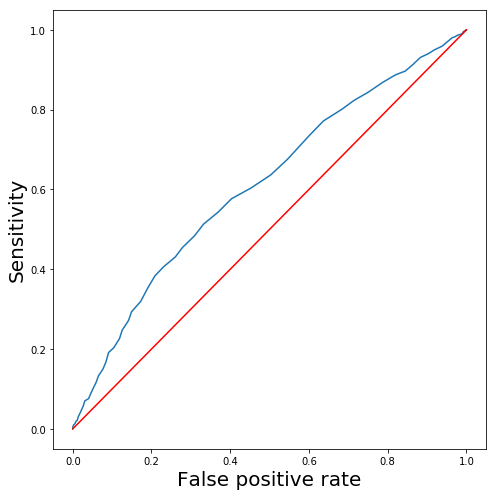

In [34]:
plot_roc(grid, X_test, y_test)

plt.savefig("./class1.png")

In [80]:
f1_score(y_test, grid.predict(X_test))

0.542271135567784

### 3.C. Out of curiosity, teasing out the features with positive regression coefficients

In [36]:

fixed_word_pipeline = Pipeline([
    ('selector', Selector(key='title')),
    ('vect', CountVectorizer(max_df=.01, ngram_range=(1,3))),
    ('tfidf', TfidfTransformer(use_idf=True))
])


wp=fixed_word_pipeline.fit(X_train, y_train)

In [37]:
fixed_nonword_pipeline = Pipeline([
    ('selector', Selector(key=nonword)),
    ('ss', StandardScaler())
])

nwp=fixed_nonword_pipeline.fit(X_train, y_train)


In [38]:
vocab=fixed_word_pipeline.named_steps['vect']

In [39]:
vocab_list=vocab.get_feature_names()

In [40]:
fu=FeatureUnion(
    [('word',wp), ('nonword', nwp)], 
    transformer_weights={'word': 0.95, 'nonword': 0.05},
)

In [41]:
features=fu.fit_transform(X_train)

In [42]:
lr=LogisticRegression(C=1, penalty='l2')


In [43]:
lr.fit(features, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
lr.coef_.ravel()

array([-0.05743394, -0.05743394, -0.05743394, ...,  1.44998829,
        0.25579605, -0.37668075])

In [45]:
featurenames=vocab_list+nonword

In [46]:
explanation=pd.DataFrame({'name':featurenames, 'coefs':lr.coef_.ravel()})

In [47]:
explanation.sort_values(by='coefs', ascending=False)[:50]

,coefs,name
62551,2.040162,subreddit_funny
62553,1.628590,subreddit_gifs
62560,1.549417,subreddit_leagueoflegends
62585,1.449988,subreddit_worldnews
62530,1.288071,subreddit_Showerthoughts
62579,1.218060,subreddit_todayilearned
20789,1.132568,game thread
62568,1.124170,subreddit_news
62558,1.092520,subreddit_hiphopheads
3901,1.057203,bad


In [48]:
explanation.loc[explanation['name']=='elapsed']

,coefs,name
62493,-0.035679,elapsed


In [49]:
explanation.loc[explanation['name']=='title_length']

,coefs,name
62494,0.615237,title_length


In [50]:
explanation.loc[explanation['name']=='feature_question']

,coefs,name
62495,-2.662597,feature_question


In [51]:
explanation.loc[explanation['name']=='feature_exclaim']

,coefs,name
62496,-0.354144,feature_exclaim


In [52]:
explanation.sort_values(by='coefs', ascending=False)[50:100]

,coefs,name
2475,0.579818,app
535,0.575405,ad
50528,0.573398,speechless
28395,0.570784,kit
5046,0.569455,better
57569,0.568006,unpopular
7657,0.567012,care
43754,0.560626,really
6147,0.560254,box
57739,0.560174,upset


### 3.D Using statsmodels to get p-values

In [53]:
X_train['intercept']=1

In [54]:
nonword_plus=nonword+['intercept']

In [55]:
logit = sm.Logit(y_train, X_train[nonword_plus])

In [56]:
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.659829
         Iterations 6


In [57]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Logit
==============================================================================
Model:                    Logit                No. Iterations:       6.0000   
Dependent Variable:       y                    Pseudo R-squared:     0.048    
Date:                     2018-06-01 21:15     AIC:                  6658.3211
No. Observations:         4900                 BIC:                  7282.0322
Df Model:                 95                   Log-Likelihood:       -3233.2  
Df Residuals:             4804                 LL-Null:              -3396.4  
Converged:                1.0000               Scale:                1.0000   
------------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------------
elapsed                         0.0000   0.0000  0.0876 0.9302 -0.0000  0.0000
title_length                    0.0038   0.0036  1.0426 0.2971 -0.0033  0.0109
feature_question               -0.5643   0.0887 -6.3604 0.0000 -0.7382 -0.3904
feature_exclaim                -0.0992   0.1176 -0.8436 0.3989 -0.3298  0.1313
subreddit_Android               2.1961   0.9270  2.3689 0.0178  0.3791  4.0130
subreddit_AskAnAmerican         2.0353   0.9366  2.1730 0.0298  0.1995  3.8711
subreddit_AskReddit             2.5596   0.7888  3.2451 0.0012  1.0136  4.1055
subreddit_BlackPeopleTwitter    0.9969   0.8867  1.1243 0.2609 -0.7409  2.7348
subreddit_Braincels             1.0431   0.9343  1.1165 0.2642 -0.7880  2.8743
subreddit_CFB                   1.7286   0.8476  2.0395 0.0414  0.0674  3.3898
subreddit_ChapoTrapHouse        1.1961   0.9157  1.3063 0.1915 -0.5986  2.9909
subreddit_Christianity          1.7192   0.9757  1.7620 0.0781 -0.1931  3.6316
subreddit_Competitiveoverwatch  2.2033   0.8882  2.4806 0.0131  0.4624  3.9442
subreddit_CringeAnarchy         1.6324   0.8984  1.8170 0.0692 -0.1285  3.3933
subreddit_CryptoCurrency        1.7067   0.9446  1.8068 0.0708 -0.1447  3.5581
subreddit_DestinyTheGame        2.6747   0.8365  3.1976 0.0014  1.0352  4.3141
subreddit_DotA2                 1.2785   0.8817  1.4501 0.1470 -0.4495  3.0066
subreddit_Drama                 1.9770   0.9742  2.0293 0.0424  0.0676  3.8865
subreddit_FireEmblemHeroes      1.1312   0.9674  1.1692 0.2423 -0.7650  3.0273
subreddit_FortNiteBR            2.1540   0.8077  2.6667 0.0077  0.5709  3.7371
subreddit_Games                 1.9069   0.9208  2.0710 0.0384  0.1022  3.7116
subreddit_GlobalOffensive       1.7352   0.8608  2.0157 0.0438  0.0480  3.4224
subreddit_Gunners               1.5943   0.9434  1.6899 0.0910 -0.2547  3.4434
subreddit_JUSTNOMIL             2.3041   0.9279  2.4831 0.0130  0.4854  4.1228
subreddit_JordanPeterson        1.1577   0.9784  1.1832 0.2367 -0.7600  3.0754
subreddit_KotakuInAction        2.3102   0.9866  2.3417 0.0192  0.3766  4.2438
subreddit_LivestreamFail        2.8400   0.9234  3.0756 0.0021  1.0302  4.6499
subreddit_MLS                   2.5911   0.9703  2.6704 0.0076  0.6893  4.4928
subreddit_MMA                   2.7027   0.8692  3.1092 0.0019  0.9990  4.4064
subreddit_MobiusFF              1.0962   0.9776  1.1213 0.2622 -0.8199  3.0122
subreddit_NintendoSwitch        2.2977   0.8893  2.5838 0.0098  0.5548  4.0407
subreddit_Overwatch             1.8693   0.8740  2.1387 0.0325  0.1562  3.5823
subreddit_PS4                   2.5485   0.9395  2.7127 0.0067  0.7072  4.3899
subreddit_PrequelMemes          1.1691   0.9394  1.2445 0.2133 -0.6721  3.0102
subreddit_PublicFreakout        2.1612   0.9619  2.2468 0.0247  0.2759  4.0466
subreddit_PurplePillDebate      2.2284   0.9245  2.4105 0.0159  0.4165  4.0404
subreddit_Rainbow6              2.6986   0.9298  2.9024 0.0037  0.8763  4.5210
subreddit_Showerthoughts        3.4711   0.9864  3.5188 0.0004  1.5377  5.4045
subreddit_SquaredCircle         1

# 4. Trying out the naive Bayes model

In [58]:
nonword_pipeline_2 = Pipeline([
    ('selector', Selector(key=nonword)),
])

In [59]:
word_pipeline_2 = Pipeline([
    ('selector', Selector(key='title')),
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])


In [60]:
merge_2 = FeatureUnion([
    ('word', word_pipeline_2),
    ('nonword', nonword_pipeline_2)
])


In [61]:
main_pipeline_2 = Pipeline([
    ('merger',merge_2),
    ('bayes', MultinomialNB()),
])

hyperparameters={
                 'merger__transformer_weights': [{'word': 0.50, 'nonword': 0.50},
                                                 {'word': 0.25, 'nonword': 0.75},
                                                 {'word': 0.75, 'nonword': 0.25}],
                 'merger__word__tfidf__use_idf': [False],
                 'merger__word__vect__max_df': [0.005, 0.01, 0.02],
                 'merger__word__vect__max_features': [500, 1000, 1500, 2000],
                 'merger__word__vect__ngram_range': [(1,1), (1, 2), (1,3), (1,4), (1, 5)]}

grid = GridSearchCV(main_pipeline_2, hyperparameters, cv=5)

In [62]:
hyperparameters={
                'merger__transformer_weights': [{'word': 0.05, 'nonword': 0.95},
                                                 {'word': 0.15, 'nonword': 0.85},
                                                 {'word': 0.25, 'nonword': 0.75}], 
                'merger__word__tfidf__use_idf': [False],
                 'merger__word__vect__max_df': [0.01],
                 'merger__word__vect__max_features': [1000],
                 'merger__word__vect__ngram_range': [(1,3)]
                }

grid = GridSearchCV(main_pipeline_2, hyperparameters, cv=5)

In [63]:
_=grid.fit(X_train, y_train)


In [64]:
grid.best_params_

{'merger__transformer_weights': {'word': 0.25, 'nonword': 0.75},
 'merger__word__tfidf__use_idf': False,
 'merger__word__vect__max_df': 0.01,
 'merger__word__vect__max_features': 1000,
 'merger__word__vect__ngram_range': (1, 3)}

In [65]:
grid.score(X_test, y_test)

0.5661904761904762

In [66]:
# f1 score is not better than Logistic Regression

In [67]:
f1_score(y_test, grid.predict(X_test))

0.5296850800206504

## 5. Trying out a Random Forest Classifier

In [68]:
nonword_pipeline_3 = Pipeline([
    ('selector', Selector(key=nonword)),
])

In [69]:
word_pipeline_3 = Pipeline([
    ('selector', Selector(key='title')),
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])


In [70]:
merge_3 = FeatureUnion([
    ('word', word_pipeline_3),
    ('nonword', nonword_pipeline_3)
])


In [71]:
main_pipeline_3 = Pipeline([
    ('merger',merge_3),
    ('forest', RandomForestClassifier()),
])

In [72]:
list(main_pipeline_3.get_params().keys())

['memory',
 'steps',
 'merger',
 'forest',
 'merger__n_jobs',
 'merger__transformer_list',
 'merger__transformer_weights',
 'merger__word',
 'merger__nonword',
 'merger__word__memory',
 'merger__word__steps',
 'merger__word__selector',
 'merger__word__vect',
 'merger__word__tfidf',
 'merger__word__selector__key',
 'merger__word__vect__analyzer',
 'merger__word__vect__binary',
 'merger__word__vect__decode_error',
 'merger__word__vect__dtype',
 'merger__word__vect__encoding',
 'merger__word__vect__input',
 'merger__word__vect__lowercase',
 'merger__word__vect__max_df',
 'merger__word__vect__max_features',
 'merger__word__vect__min_df',
 'merger__word__vect__ngram_range',
 'merger__word__vect__preprocessor',
 'merger__word__vect__stop_words',
 'merger__word__vect__strip_accents',
 'merger__word__vect__token_pattern',
 'merger__word__vect__tokenizer',
 'merger__word__vect__vocabulary',
 'merger__word__tfidf__norm',
 'merger__word__tfidf__smooth_idf',
 'merger__word__tfidf__sublinear_tf',
 

In [73]:
hyperparameters={
                'merger__transformer_weights': [
                                                 {'word': 0.25, 'nonword': 0.75}], 
                'merger__word__tfidf__use_idf': [False],
                 'merger__word__vect__max_df': [.03],
                 'merger__word__vect__ngram_range': [(1,3)],
                'forest__min_samples_split': [2, 10, 20],
                'forest__min_impurity_decrease':[0],
                'forest__max_depth':[10, 50, 200]
                }

grid = GridSearchCV(main_pipeline_3, hyperparameters, cv=5)

In [74]:
_=grid.fit(X_train, y_train)

In [75]:
grid.best_params_

{'forest__max_depth': 200,
 'forest__min_impurity_decrease': 0,
 'forest__min_samples_split': 20,
 'merger__transformer_weights': {'word': 0.25, 'nonword': 0.75},
 'merger__word__tfidf__use_idf': False,
 'merger__word__vect__max_df': 0.03,
 'merger__word__vect__ngram_range': (1, 3)}

In [76]:
grid.score(X_test, y_test)

0.5642857142857143

In [77]:
grid.score(X_train, y_train)

0.8673469387755102

In [78]:
f1_score(y_test, grid.predict(X_test))

0.542271135567784

## Random Forest has equivalent strength to Logistic Regression, which had an f1 score of .54